In [1]:
import librosa.display
from dotenv import load_dotenv
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# 指定 STFT 參數
load_dotenv()
sample_rate = int(os.getenv('sample_rate'))
n_mels = int(os.getenv('n_mels'))
# n_fft = int(os.getenv('n_fft'))

print(f'Sample rate: {sample_rate}, n_mels: {n_mels}')

Sample rate: 48000, n_mels: 128


In [3]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split

def load_segmented_files(directory):
    wav_files = []
    leak_wav_files = []
    for dir in os.listdir(directory):
        if not os.path.isdir(os.path.join(directory, dir)):
            continue
        for file in os.listdir(os.path.join(directory, dir)):
            if not file.endswith(".wav"):
                continue
            file_path = os.path.join(directory, dir, file)
            y, sr = librosa.load(file_path, sr=None)
            filename = f'{dir}_{file}'
            if 'no-leak' in dir:
                wav_files.append((y, sr, filename))
            else:
                leak_wav_files.append((y, sr, filename))
    return wav_files, leak_wav_files

def create_dataset(directory, max_length=None):
    wav_files, leak_wav_files = load_segmented_files(directory)
    
    # 將資料轉為 NumPy 格式
    X = []
    y = []
    
    for audio, sr, filename in wav_files:
        X.append((audio, sr))
        y.append(0)  # wav_files 標記為 0
    
    for audio, sr, filename in leak_wav_files:
        X.append((audio, sr))
        y.append(1)  # leak_wav_files 標記為 1
    
    return X, np.array(y)

# 使用範例
directory = 'training_data'
X, y = create_dataset(directory)

print(f"總樣本數: {len(X)}")
print(f"標籤分佈: {np.bincount(y)}")


總樣本數: 12717
標籤分佈: [10641  2076]


In [4]:
def extract_features(audio, sr, n_mels=128, n_fft=2048, hop_length=512, max_len=128):
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # 轉置以符合 (時間, 頻率) 的形狀
    log_mel_spectrogram = log_mel_spectrogram.T  # 形狀變為 (時間, n_mels)
    
    # 填充或截斷至 max_len
    if log_mel_spectrogram.shape[0] < max_len:
        pad_width = max_len - log_mel_spectrogram.shape[0]
        log_mel_spectrogram = np.pad(log_mel_spectrogram, ((0, pad_width), (0, 0)), mode='constant')
    else:
        log_mel_spectrogram = log_mel_spectrogram[:max_len, :]
    
    return log_mel_spectrogram

def preprocess_data(X, max_len=128):
    features = []
    for audio, sr in X:
        feature = extract_features(audio, sr, max_len=max_len)
        features.append(feature)
    return np.array(features)

# 預處理資料
max_len = 128  # 您可以根據需求調整
X_features = preprocess_data(X, max_len=max_len)

print(f"特徵形狀: {X_features.shape}")  # 預期形狀: (樣本數, max_len, n_mels)


特徵形狀: (12717, 128, 128)


In [5]:
# 正規化特徵
X_features = (X_features - np.mean(X_features)) / np.std(X_features)

# 擴展維度以符合 CNN 輸入 (樣本數, 高, 寬, 通道)
X_features = np.expand_dims(X_features, -1)  # 新形狀: (樣本數, max_len, n_mels, 1)

# 分割訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

print(f"訓練集形狀: {X_train.shape}")
print(f"測試集形狀: {X_test.shape}")


訓練集形狀: (10173, 128, 128, 1)
測試集形狀: (2544, 128, 128, 1)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_cnn_model(input_shape=(128, 128, 1)):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))  # 二元分類使用 sigmoid 激活函數
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 建立模型
input_shape = (128, 128, 1)  # 調整後的頻譜圖形狀
model = create_cnn_model(input_shape)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 64)        0

In [7]:
# 假設 X_train 和 X_test 經過特徵提取並已調整維度
X_train_expanded = np.expand_dims(X_train, -1)
X_test_expanded = np.expand_dims(X_test, -1)

# 訓練模型
history = model.fit(X_train_expanded, y_train, epochs=30, batch_size=32, validation_data=(X_test_expanded, y_test))


Epoch 1/30
318/318 [==============================] - 12s 16ms/step - loss: 0.4124 - accuracy: 0.8315 - val_loss: 0.3283 - val_accuracy: 0.8518
Epoch 2/30
318/318 [==============================] - 5s 15ms/step - loss: 0.3474 - accuracy: 0.8330 - val_loss: 0.3028 - val_accuracy: 0.8518
Epoch 3/30
318/318 [==============================] - 5s 15ms/step - loss: 0.3343 - accuracy: 0.8435 - val_loss: 0.2886 - val_accuracy: 0.8813
Epoch 4/30
318/318 [==============================] - 5s 15ms/step - loss: 0.3161 - accuracy: 0.8712 - val_loss: 0.2778 - val_accuracy: 0.8801
Epoch 5/30
318/318 [==============================] - 5s 15ms/step - loss: 0.3022 - accuracy: 0.8831 - val_loss: 0.2690 - val_accuracy: 0.8770
Epoch 6/30
318/318 [==============================] - 5s 15ms/step - loss: 0.2970 - accuracy: 0.8842 - val_loss: 0.2665 - val_accuracy: 0.8872
Epoch 7/30
318/318 [==============================] - 5s 15ms/step - loss: 0.2933 - accuracy: 0.8855 - val_loss: 0.2674 - val_accuracy: 0.895

In [8]:
# 評估模型
test_loss, test_accuracy = model.evaluate(X_test_expanded, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")


80/80 [==============================] - 0s 5ms/step - loss: 0.2696 - accuracy: 0.9045
Test accuracy: 0.90


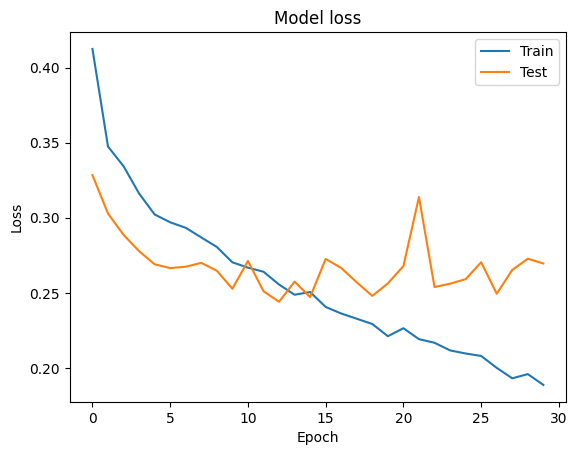

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig('model_loss.png')
plt.show()